Importo le librerie necessarie

In [2]:
!pip install chefboost
import pandas as pd
from chefboost import Chefboost as chef


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Genero un dataset di voli da etichettare manualmente.
Questi serviranno per costruire il decision tree.

In [3]:
import csv 
import random
import os 

#lista delle città
città = ['Roma', 'Milano', 'Berlino', 'Madrid', 'Parigi', 'Londra', 'Amsterdam']

N_test = 1000
#lista compagnie aeree
compagnie = ['Lufthansa', 'EasyJet', 'Ryanair', 'Iberia', 'Wizz Air']

if not os.path.exists("voli_train.csv"):
  N_train = int(input('Quanti voli vuoi etichettare?'))
  while N_train <= 0:
    print("Devi etichettare almeno qualche volo....")
    N_train = int(input('Quanti voli vuoi etichettare?'))


  #scrivo il file CSV
  with open('voli_train.csv', 'w') as csvfile:
      writer = csv.writer(csvfile, delimiter=',')
      writer.writerow(['Partenza', 'Destinazione', 'Compagnia', 'Numero di scali', 'Costo', 'Durata', 'Decision'])
      
      for i in range(N_train):
          partenza, destinazione = random.sample(città, 2)
          compagnia = random.choice(compagnie)
          n_scali = random.randint(0,2)
          costo = random.randint(50,250)
          durata = random.randint(100,240)
        
          print(f"Partenza: {partenza}")
          print(f"Destinazione: {destinazione}")
          print(f"N. Scali: {n_scali}")
          print(f"Costo: {costo}")
          print(f"Durata: {durata//60:02d}:{durata%60:02d}")
          decisione = 'Yes' if str(input("Questo volo è consigliabile?(S/N)")).lower() == "s" else 'No'
          print("#"*20)
        
          writer.writerow([partenza, destinazione, compagnia, n_scali, costo, durata, decisione])


Riepilogo dei dati generati

In [4]:
voli_train_df = pd.read_csv('voli_train.csv')

voli_train_df


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata  \
0         Roma       Londra  Lufthansa                2     69     162   
1       Milano       Londra    Ryanair                0     66     190   
2         Roma       Madrid  Lufthansa                1     89     120   
3       Parigi         Roma    EasyJet                1    177     109   
4       Milano      Berlino   Wizz Air                0    109     154   
..         ...          ...        ...              ...    ...     ...   
295  Amsterdam       Londra    Ryanair                1     75     132   
296    Berlino         Roma     Iberia                2    226     172   
297  Amsterdam       Londra  Lufthansa                2     82     143   
298     Parigi      Berlino  Lufthansa                1    239     206   
299       Roma      Berlino   Wizz Air                0     54     130   

    Decision  
0        Yes  
1        Yes  
2        Yes  
3         No  
4        Yes  
..       ...  
295      Yes  
296       No  
297      Yes  
298       No  
299      Yes  

[300 rows x 7 columns]

Creo il decision tree con CART


In [5]:
config = {'algorithm': 'ID3', 'max_depth': 6, 'enableParallelism': True, 'num_cores': 2}
while True:
  try:
    model = chef.fit(voli_train_df.copy(), config = config, target_label = 'Decision')
    break
  except:
    pass

[INFO]:  2 CPU cores will be allocated in parallel running
ID3  tree is going to be built...
-------------------------
finished in  1.522428035736084  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  300  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[126, 0], [0, 174]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


Visualizzo la funzione generata

In [6]:
function_path = "outputs/rules/rules.py"
with open("outputs/rules/rules.py", "r") as f:
    print(f.read())

def findDecision(obj): #obj[0]: Partenza, obj[1]: Destinazione, obj[2]: Compagnia, obj[3]: Numero di scali, obj[4]: Costo, obj[5]: Durata
	# {"feature": "Numero di scali", "instances": 300, "metric_value": 0.9815, "depth": 1}
	if obj[3]>0:
		# {"feature": "Costo", "instances": 201, "metric_value": 0.7846, "depth": 2}
		if obj[4]>148.77114427860695:
			return 'No'
		elif obj[4]<=148.77114427860695:
			# {"feature": "Durata", "instances": 96, "metric_value": 0.9997, "depth": 3}
			if obj[5]>169.76041666666666:
				return 'No'
			elif obj[5]<=169.76041666666666:
				return 'Yes'
			else: return 'Yes'
		else: return 'No'
	elif obj[3]<=0:
		# {"feature": "Costo", "instances": 99, "metric_value": 0.726, "depth": 2}
		if obj[4]<=145.95959595959596:
			return 'Yes'
		elif obj[4]>145.95959595959596:
			# {"feature": "Durata", "instances": 46, "metric_value": 0.9877, "depth": 3}
			if obj[5]<=165.97826086956522:
				return 'Yes'
			elif obj[5]>165.97826086956522:
				# {"feature": "Partenza", "i

Analisi l'importanza delle singole feature

Decision rule:  outputs/rules/rules.py


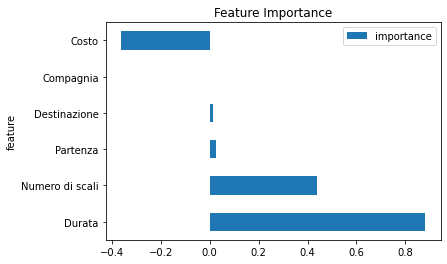

In [7]:
rules = "outputs/rules/rules.py"
fi = chef.feature_importance(rules).set_index('feature')
fi
fi.plot(kind="barh", title="Feature Importance");

Genero un file con dei voli casuali che verranno etichettati in base al modello creato nei punti precedenti.

In [8]:
#scrivo il file CSV
with open('voli_test.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Partenza', 'Destinazione', 'Compagnia', 'Numero di scali', 'Costo', 'Durata', 'Decision'])
    
    for i in range(N_test):
        partenza, destinazione = random.sample(città, 2)
        compagnia = random.choice(compagnie)
        n_scali = random.randint(0,2)
        costo = random.randint(50,250)
        durata = random.randint(100,240)
        decisione = chef.predict(model, param=[partenza, destinazione, compagnia, n_scali, costo, durata])
        writer.writerow([partenza, destinazione, compagnia, n_scali, costo, durata, decisione])

Per ogni coppia partenza-destinazione, stampo i voli migliori

In [10]:
from itertools import permutations
voli_test_df = pd.read_csv('voli_test.csv')
for partenza, destinazione in permutations(città,2):
  print(f"Voli {partenza}-{destinazione}")
  display(voli_test_df.loc[(voli_test_df['Partenza']==partenza) & (voli_test_df['Destinazione']==destinazione) & (voli_test_df['Decision']=='Yes')].sort_values([ 'Costo', 'Durata', 'Numero di scali']))
  print("\n"*3)

Voli Roma-Milano


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
258     Roma       Milano   Wizz Air                0     50     129      Yes
279     Roma       Milano   Wizz Air                1     54     143      Yes
789     Roma       Milano  Lufthansa                0     61     130      Yes
431     Roma       Milano    Ryanair                0     72     137      Yes
905     Roma       Milano    Ryanair                0    106     151      Yes
717     Roma       Milano    EasyJet                2    110     111      Yes
868     Roma       Milano  Lufthansa                2    113     162      Yes
31      Roma       Milano     Iberia                0    124     170      Yes
364     Roma       Milano   Wizz Air                1    125     163      Yes
68      Roma       Milano  Lufthansa                0    193     116      Yes
881     Roma       Milano   Wizz Air                0    203     108      Yes
768     Roma       Milano    EasyJet                0    245     128      Yes





Voli Roma-Berlino


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
578     Roma      Berlino   EasyJet                2     58     142      Yes
293     Roma      Berlino    Iberia                1     85     149      Yes
482     Roma      Berlino  Wizz Air                0     97     186      Yes
630     Roma      Berlino   Ryanair                2    115     131      Yes
636     Roma      Berlino    Iberia                2    123     102      Yes
398     Roma      Berlino  Wizz Air                0    131     236      Yes
833     Roma      Berlino    Iberia                0    202     110      Yes





Voli Roma-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
151     Roma       Madrid    Ryanair                2     61     160      Yes
719     Roma       Madrid  Lufthansa                0     81     174      Yes
252     Roma       Madrid    EasyJet                0     85     229      Yes
992     Roma       Madrid    Ryanair                0    130     223      Yes
689     Roma       Madrid    EasyJet                0    187     163      Yes





Voli Roma-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
333     Roma       Parigi   Wizz Air                0     53     237      Yes
890     Roma       Parigi    EasyJet                0     70     142      Yes
604     Roma       Parigi  Lufthansa                1     73     105      Yes
22      Roma       Parigi    Ryanair                1     84     127      Yes
423     Roma       Parigi    EasyJet                2     88     100      Yes
403     Roma       Parigi    EasyJet                0    116     150      Yes
209     Roma       Parigi    EasyJet                0    121     171      Yes
872     Roma       Parigi   Wizz Air                0    210     139      Yes
104     Roma       Parigi   Wizz Air                0    228     160      Yes
950     Roma       Parigi    EasyJet                0    244     164      Yes





Voli Roma-Londra


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
562     Roma       Londra  Lufthansa                0     51     232      Yes
178     Roma       Londra    Ryanair                0     68     124      Yes
933     Roma       Londra   Wizz Air                0     73     148      Yes
600     Roma       Londra    Ryanair                0    118     187      Yes
656     Roma       Londra    EasyJet                0    119     144      Yes
82      Roma       Londra   Wizz Air                0    156     124      Yes
853     Roma       Londra     Iberia                0    216     130      Yes





Voli Roma-Amsterdam


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
316     Roma    Amsterdam   Wizz Air                0     58     122      Yes
830     Roma    Amsterdam    EasyJet                1     96     127      Yes
860     Roma    Amsterdam  Lufthansa                0     99     106      Yes
567     Roma    Amsterdam    Ryanair                0    121     127      Yes
284     Roma    Amsterdam    Ryanair                2    124     168      Yes
931     Roma    Amsterdam  Lufthansa                1    130     112      Yes
352     Roma    Amsterdam     Iberia                0    137     135      Yes
76      Roma    Amsterdam    Ryanair                1    138     158      Yes
235     Roma    Amsterdam  Lufthansa                0    157     159      Yes
772     Roma    Amsterdam   Wizz Air                0    178     119      Yes
303     Roma    Amsterdam    EasyJet                0    214     151      Yes





Voli Milano-Roma


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
989   Milano         Roma    EasyJet                1     70     156      Yes
559   Milano         Roma   Wizz Air                0     89     101      Yes
994   Milano         Roma   Wizz Air                0    107     168      Yes
734   Milano         Roma   Wizz Air                2    112     142      Yes
281   Milano         Roma  Lufthansa                0    127     224      Yes
754   Milano         Roma  Lufthansa                2    137     153      Yes
435   Milano         Roma     Iberia                1    148     164      Yes





Voli Milano-Berlino


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
982   Milano      Berlino   Wizz Air                0     69     227      Yes
399   Milano      Berlino   Wizz Air                0     72     212      Yes
999   Milano      Berlino  Lufthansa                0     90     153      Yes
599   Milano      Berlino    Ryanair                0     98     225      Yes
560   Milano      Berlino    Ryanair                0    106     184      Yes
232   Milano      Berlino    Ryanair                0    125     222      Yes
569   Milano      Berlino     Iberia                2    126     129      Yes
971   Milano      Berlino    Ryanair                2    139     156      Yes
852   Milano      Berlino    Ryanair                2    141     106      Yes
712   Milano      Berlino   Wizz Air                0    191     111      Yes





Voli Milano-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
420   Milano       Madrid  Lufthansa                0     65     196      Yes
869   Milano       Madrid    Ryanair                1     96     148      Yes
379   Milano       Madrid    EasyJet                0    111     200      Yes
463   Milano       Madrid  Lufthansa                1    112     124      Yes
236   Milano       Madrid    EasyJet                0    114     234      Yes
644   Milano       Madrid     Iberia                0    134     234      Yes
59    Milano       Madrid    EasyJet                0    143     181      Yes
170   Milano       Madrid    Ryanair                2    145     156      Yes
592   Milano       Madrid    Ryanair                0    191     113      Yes





Voli Milano-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
998   Milano       Parigi  Lufthansa                1     54     162      Yes
247   Milano       Parigi   Wizz Air                0     63     168      Yes
149   Milano       Parigi    EasyJet                0     69     201      Yes
116   Milano       Parigi  Lufthansa                2     97     145      Yes
610   Milano       Parigi  Lufthansa                2    104     150      Yes
837   Milano       Parigi  Lufthansa                0    108     196      Yes
447   Milano       Parigi     Iberia                1    112     131      Yes
577   Milano       Parigi  Lufthansa                0    115     138      Yes
981   Milano       Parigi     Iberia                0    135     210      Yes
612   Milano       Parigi    Ryanair                0    140     228      Yes
679   Milano       Parigi   Wizz Air                0    141     235      Yes
113   Milano       Parigi    Ryanair                0    164     114      Yes
941   Milano       Parigi    EasyJet                0    225     143      Yes





Voli Milano-Londra


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
919   Milano       Londra  Lufthansa                1     50     129      Yes
820   Milano       Londra  Lufthansa                0     51     163      Yes
263   Milano       Londra     Iberia                1     74     121      Yes
554   Milano       Londra   Wizz Air                0    119     168      Yes
854   Milano       Londra    Ryanair                1    135     102      Yes
440   Milano       Londra    EasyJet                0    173     120      Yes
973   Milano       Londra    EasyJet                0    193     108      Yes
83    Milano       Londra   Wizz Air                0    220     101      Yes





Voli Milano-Amsterdam


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
191   Milano    Amsterdam   Ryanair                1     53     134      Yes
794   Milano    Amsterdam    Iberia                2     53     136      Yes
24    Milano    Amsterdam   Ryanair                1     54     117      Yes
203   Milano    Amsterdam  Wizz Air                2     85     116      Yes
930   Milano    Amsterdam   EasyJet                1    113     122      Yes
573   Milano    Amsterdam  Wizz Air                2    131     107      Yes
278   Milano    Amsterdam   Ryanair                0    138     120      Yes
661   Milano    Amsterdam    Iberia                0    156     161      Yes





Voli Berlino-Roma


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
909  Berlino         Roma   Ryanair                1     50     137      Yes
863  Berlino         Roma   EasyJet                1     51     151      Yes
918  Berlino         Roma   EasyJet                0     55     117      Yes
234  Berlino         Roma  Wizz Air                2     57     142      Yes
678  Berlino         Roma  Wizz Air                2     78     100      Yes
129  Berlino         Roma  Wizz Air                2     89     161      Yes
553  Berlino         Roma   EasyJet                0     92     199      Yes
307  Berlino         Roma   EasyJet                0     95     133      Yes
385  Berlino         Roma   EasyJet                0     95     160      Yes
515  Berlino         Roma  Wizz Air                2    102     138      Yes
766  Berlino         Roma  Wizz Air                0    102     150      Yes
88   Berlino         Roma   EasyJet                0    137     122      Yes
360  Berlino         Roma   EasyJet                0    144     166      Yes
369  Berlino         Roma  Wizz Air                0    177     126      Yes





Voli Berlino-Milano


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
621  Berlino       Milano   Wizz Air                0     98     106      Yes
325  Berlino       Milano    Ryanair                2    130     162      Yes
150  Berlino       Milano  Lufthansa                2    133     129      Yes
937  Berlino       Milano     Iberia                2    142     155      Yes
743  Berlino       Milano  Lufthansa                2    143     102      Yes
737  Berlino       Milano    EasyJet                0    191     115      Yes





Voli Berlino-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
443  Berlino       Madrid  Lufthansa                0     55     113      Yes
802  Berlino       Madrid    Ryanair                0     58     161      Yes
896  Berlino       Madrid  Lufthansa                0     64     119      Yes
583  Berlino       Madrid     Iberia                0     93     198      Yes
271  Berlino       Madrid   Wizz Air                0    146     121      Yes





Voli Berlino-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
637  Berlino       Parigi     Iberia                0     58     220      Yes
940  Berlino       Parigi   Wizz Air                1     61     125      Yes
215  Berlino       Parigi    Ryanair                1     88     129      Yes
572  Berlino       Parigi    EasyJet                0    112     231      Yes
430  Berlino       Parigi  Lufthansa                0    133     108      Yes
602  Berlino       Parigi    Ryanair                0    138     146      Yes
429  Berlino       Parigi     Iberia                2    141     165      Yes
94   Berlino       Parigi     Iberia                0    221     111      Yes
744  Berlino       Parigi     Iberia                0    247     140      Yes





Voli Berlino-Londra


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
721  Berlino       Londra     Iberia                0     93     134      Yes
547  Berlino       Londra  Lufthansa                1    102     130      Yes
91   Berlino       Londra    EasyJet                2    123     123      Yes
46   Berlino       Londra   Wizz Air                2    123     154      Yes
462  Berlino       Londra    EasyJet                2    128     103      Yes
358  Berlino       Londra  Lufthansa                1    128     154      Yes
17   Berlino       Londra     Iberia                0    190     108      Yes





Voli Berlino-Amsterdam


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
706  Berlino    Amsterdam    Iberia                1     59     130      Yes
829  Berlino    Amsterdam    Iberia                2     66     159      Yes
3    Berlino    Amsterdam  Wizz Air                0     66     234      Yes
922  Berlino    Amsterdam  Wizz Air                1     69     154      Yes
650  Berlino    Amsterdam   EasyJet                2     71     147      Yes
87   Berlino    Amsterdam    Iberia                1     72     166      Yes
846  Berlino    Amsterdam   EasyJet                2     77     104      Yes
146  Berlino    Amsterdam    Iberia                0    139     210      Yes
311  Berlino    Amsterdam   EasyJet                0    140     102      Yes
310  Berlino    Amsterdam   Ryanair                0    141     193      Yes
510  Berlino    Amsterdam   Ryanair                0    225     136      Yes





Voli Madrid-Roma


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
377   Madrid         Roma  Lufthansa                2     58     111      Yes
225   Madrid         Roma    EasyJet                2     66     142      Yes
911   Madrid         Roma    EasyJet                2     71     103      Yes
780   Madrid         Roma     Iberia                1     93     103      Yes
787   Madrid         Roma    EasyJet                1    106     140      Yes
132   Madrid         Roma   Wizz Air                0    110     155      Yes
147   Madrid         Roma     Iberia                0    112     192      Yes
37    Madrid         Roma    EasyJet                0    117     198      Yes
14    Madrid         Roma     Iberia                2    121     158      Yes
645   Madrid         Roma    EasyJet                1    141     128      Yes
790   Madrid         Roma   Wizz Air                0    168     106      Yes
673   Madrid         Roma     Iberia                0    174     142      Yes
158   Madrid         Roma   Wizz Air                0    190     107      Yes
759   Madrid         Roma  Lufthansa                0    223     127      Yes





Voli Madrid-Milano


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
864   Madrid       Milano    EasyJet                2     61     154      Yes
40    Madrid       Milano    EasyJet                0     90     209      Yes
785   Madrid       Milano   Wizz Air                0     92     220      Yes
367   Madrid       Milano  Lufthansa                0     99     116      Yes
774   Madrid       Milano  Lufthansa                0    110     125      Yes
828   Madrid       Milano   Wizz Air                0    121     148      Yes
164   Madrid       Milano    EasyJet                2    143     116      Yes
305   Madrid       Milano    EasyJet                0    143     159      Yes
233   Madrid       Milano     Iberia                0    203     123      Yes
561   Madrid       Milano     Iberia                0    222     100      Yes





Voli Madrid-Berlino


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
489   Madrid      Berlino    EasyJet                0     75     113      Yes
402   Madrid      Berlino     Iberia                0     78     216      Yes
952   Madrid      Berlino     Iberia                0     90     127      Yes
551   Madrid      Berlino    Ryanair                1     95     149      Yes
735   Madrid      Berlino    EasyJet                0     95     237      Yes
231   Madrid      Berlino   Wizz Air                0    118     232      Yes
775   Madrid      Berlino    EasyJet                1    119     100      Yes
507   Madrid      Berlino    Ryanair                1    124     152      Yes
655   Madrid      Berlino     Iberia                0    124     212      Yes
575   Madrid      Berlino    Ryanair                0    129     227      Yes
332   Madrid      Berlino    EasyJet                0    142     116      Yes
253   Madrid      Berlino    Ryanair                2    143     144      Yes
99    Madrid      Berlino  Lufthansa                1    145     114      Yes
657   Madrid      Berlino    Ryanair                0    234     152      Yes





Voli Madrid-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
89    Madrid       Parigi    Ryanair                0     53     206      Yes
677   Madrid       Parigi   Wizz Air                0     59     183      Yes
958   Madrid       Parigi   Wizz Air                1     65     134      Yes
767   Madrid       Parigi   Wizz Air                1     81     154      Yes
192   Madrid       Parigi    EasyJet                0     84     193      Yes
730   Madrid       Parigi    Ryanair                2     91     149      Yes
71    Madrid       Parigi    Ryanair                1     92     148      Yes
807   Madrid       Parigi     Iberia                1    104     127      Yes
424   Madrid       Parigi     Iberia                2    104     139      Yes
222   Madrid       Parigi  Lufthansa                0    107     103      Yes
641   Madrid       Parigi     Iberia                0    133     154      Yes
460   Madrid       Parigi   Wizz Air                1    134     168      Yes
464   Madrid       Parigi    Ryanair                0    203     151      Yes
342   Madrid       Parigi  Lufthansa                0    220     113      Yes





Voli Madrid-Londra


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
380   Madrid       Londra  Lufthansa                2     52     149      Yes
404   Madrid       Londra     Iberia                0     58     206      Yes
177   Madrid       Londra     Iberia                0     61     125      Yes
255   Madrid       Londra  Lufthansa                1     66     120      Yes
29    Madrid       Londra    EasyJet                2     73     131      Yes
682   Madrid       Londra    Ryanair                0     86     184      Yes
653   Madrid       Londra  Lufthansa                2    131     168      Yes
710   Madrid       Londra     Iberia                0    132     175      Yes
874   Madrid       Londra     Iberia                2    141     108      Yes
985   Madrid       Londra   Wizz Air                0    141     130      Yes
126   Madrid       Londra   Wizz Air                0    237     140      Yes





Voli Madrid-Amsterdam


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
616   Madrid    Amsterdam     Iberia                2     74     124      Yes
526   Madrid    Amsterdam  Lufthansa                0    149     122      Yes
241   Madrid    Amsterdam     Iberia                0    174     102      Yes
906   Madrid    Amsterdam    EasyJet                0    181     127      Yes
586   Madrid    Amsterdam   Wizz Air                0    201     128      Yes





Voli Parigi-Roma


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
92    Parigi         Roma   Ryanair                0     50     217      Yes
290   Parigi         Roma  Wizz Air                1     56     145      Yes
684   Parigi         Roma  Wizz Air                1     63     139      Yes
244   Parigi         Roma   Ryanair                0     72     156      Yes
995   Parigi         Roma   EasyJet                2     78     101      Yes
724   Parigi         Roma    Iberia                2    102     118      Yes
595   Parigi         Roma  Wizz Air                2    119     119      Yes
591   Parigi         Roma   EasyJet                0    215     138      Yes





Voli Parigi-Milano


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
213   Parigi       Milano   Wizz Air                0     50     179      Yes
69    Parigi       Milano  Lufthansa                0     73     116      Yes
162   Parigi       Milano    Ryanair                0     76     223      Yes
972   Parigi       Milano  Lufthansa                2     77     168      Yes
259   Parigi       Milano    Ryanair                0     78     237      Yes
840   Parigi       Milano   Wizz Air                0    122     115      Yes
348   Parigi       Milano    Ryanair                1    122     150      Yes
491   Parigi       Milano   Wizz Air                0    131     177      Yes
375   Parigi       Milano     Iberia                0    133     191      Yes
334   Parigi       Milano    EasyJet                2    139     146      Yes
745   Parigi       Milano  Lufthansa                2    148     157      Yes
54    Parigi       Milano   Wizz Air                0    156     128      Yes
861   Parigi       Milano  Lufthansa                0    249     119      Yes





Voli Parigi-Berlino


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
647   Parigi      Berlino    Ryanair                0     56     148      Yes
477   Parigi      Berlino     Iberia                1     86     130      Yes
932   Parigi      Berlino   Wizz Air                0    110     151      Yes
882   Parigi      Berlino    EasyJet                2    120     130      Yes
920   Parigi      Berlino   Wizz Air                1    124     111      Yes
929   Parigi      Berlino    Ryanair                1    132     130      Yes
223   Parigi      Berlino  Lufthansa                1    147     107      Yes
613   Parigi      Berlino  Lufthansa                0    147     139      Yes
980   Parigi      Berlino  Lufthansa                0    244     133      Yes





Voli Parigi-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
668   Parigi       Madrid   Wizz Air                0     53     118      Yes
453   Parigi       Madrid   Wizz Air                0     57     131      Yes
405   Parigi       Madrid    EasyJet                2     69     115      Yes
654   Parigi       Madrid  Lufthansa                2    114     107      Yes
135   Parigi       Madrid   Wizz Air                1    119     124      Yes
691   Parigi       Madrid     Iberia                2    122     166      Yes





Voli Parigi-Londra


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
53    Parigi       Londra   Wizz Air                0     79     218      Yes
260   Parigi       Londra  Lufthansa                0     80     129      Yes
556   Parigi       Londra    Ryanair                2     83     127      Yes
704   Parigi       Londra    EasyJet                1     92     150      Yes
28    Parigi       Londra    Ryanair                0     92     220      Yes
492   Parigi       Londra     Iberia                1    110     105      Yes
127   Parigi       Londra  Lufthansa                0    119     123      Yes
648   Parigi       Londra  Lufthansa                2    129     165      Yes
686   Parigi       Londra  Lufthansa                0    140     127      Yes
942   Parigi       Londra    EasyJet                2    145     162      Yes
36    Parigi       Londra    Ryanair                0    150     155      Yes
884   Parigi       Londra  Lufthansa                0    152     149      Yes
312   Parigi       Londra   Wizz Air                0    167     164      Yes





Voli Parigi-Amsterdam


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
913   Parigi    Amsterdam    EasyJet                2     59     109      Yes
414   Parigi    Amsterdam  Lufthansa                2     62     140      Yes
886   Parigi    Amsterdam  Lufthansa                2     63     141      Yes
102   Parigi    Amsterdam  Lufthansa                2     73     153      Yes
297   Parigi    Amsterdam  Lufthansa                0    100     154      Yes
503   Parigi    Amsterdam     Iberia                0    104     155      Yes
344   Parigi    Amsterdam  Lufthansa                0    114     107      Yes
729   Parigi    Amsterdam     Iberia                2    130     168      Yes
747   Parigi    Amsterdam     Iberia                2    137     117      Yes
321   Parigi    Amsterdam    EasyJet                0    139     110      Yes
511   Parigi    Amsterdam    EasyJet                0    197     157      Yes
189   Parigi    Amsterdam  Lufthansa                0    221     134      Yes
670   Parigi    Amsterdam    Ryanair                0    245     138      Yes





Voli Londra-Roma


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
456   Londra         Roma    Ryanair                0     73     124      Yes
204   Londra         Roma  Lufthansa                1     76     102      Yes
859   Londra         Roma     Iberia                0     86     233      Yes
527   Londra         Roma     Iberia                2     99     117      Yes
400   Londra         Roma    EasyJet                0    134     224      Yes
237   Londra         Roma  Lufthansa                0    145     218      Yes
123   Londra         Roma    EasyJet                0    161     116      Yes
326   Londra         Roma    Ryanair                0    208     112      Yes
870   Londra         Roma     Iberia                0    230     123      Yes





Voli Londra-Milano


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
946   Londra       Milano   Ryanair                2     89     119      Yes
843   Londra       Milano   EasyJet                1    105     153      Yes
6     Londra       Milano   Ryanair                1    110     120      Yes
319   Londra       Milano   Ryanair                0    116     196      Yes
606   Londra       Milano   Ryanair                0    122     213      Yes
782   Londra       Milano   EasyJet                0    125     163      Yes
67    Londra       Milano   EasyJet                2    130     164      Yes
953   Londra       Milano    Iberia                0    184     105      Yes
137   Londra       Milano   Ryanair                0    234     163      Yes





Voli Londra-Berlino


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
714   Londra      Berlino   Wizz Air                0     52     125      Yes
256   Londra      Berlino    EasyJet                0     53     101      Yes
849   Londra      Berlino    Ryanair                2     78     153      Yes
275   Londra      Berlino     Iberia                1     85     120      Yes
818   Londra      Berlino     Iberia                0     92     103      Yes
291   Londra      Berlino  Lufthansa                1    117     152      Yes
634   Londra      Berlino   Wizz Air                0    134     212      Yes
481   Londra      Berlino  Lufthansa                0    169     101      Yes
927   Londra      Berlino  Lufthansa                0    175     123      Yes





Voli Londra-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
548   Londra       Madrid  Lufthansa                2     52     116      Yes
692   Londra       Madrid    Ryanair                0     52     162      Yes
877   Londra       Madrid    EasyJet                0     83     115      Yes
143   Londra       Madrid   Wizz Air                2     87     124      Yes
154   Londra       Madrid    Ryanair                0     87     148      Yes
459   Londra       Madrid  Lufthansa                1    107     109      Yes
815   Londra       Madrid   Wizz Air                0    136     104      Yes
428   Londra       Madrid    EasyJet                2    141     113      Yes
786   Londra       Madrid    Ryanair                0    168     116      Yes
836   Londra       Madrid   Wizz Air                0    188     126      Yes





Voli Londra-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
409   Londra       Parigi  Lufthansa                0     52     134      Yes
842   Londra       Parigi   Wizz Air                0     80     164      Yes
628   Londra       Parigi   Wizz Air                0     90     132      Yes
826   Londra       Parigi     Iberia                1     93     145      Yes
112   Londra       Parigi    EasyJet                2    100     139      Yes
378   Londra       Parigi    Ryanair                2    110     166      Yes
803   Londra       Parigi  Lufthansa                0    151     134      Yes
738   Londra       Parigi  Lufthansa                0    189     103      Yes
391   Londra       Parigi    Ryanair                0    198     161      Yes
708   Londra       Parigi   Wizz Air                0    199     150      Yes
206   Londra       Parigi    Ryanair                0    239     145      Yes





Voli Londra-Amsterdam


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
867   Londra    Amsterdam    Ryanair                0     53     146      Yes
720   Londra    Amsterdam  Lufthansa                2     57     146      Yes
114   Londra    Amsterdam  Lufthansa                0     60     219      Yes
64    Londra    Amsterdam   Wizz Air                0     87     121      Yes
70    Londra    Amsterdam  Lufthansa                0    104     115      Yes
196   Londra    Amsterdam    Ryanair                1    111     141      Yes
216   Londra    Amsterdam    Ryanair                0    135     122      Yes
800   Londra    Amsterdam     Iberia                0    217     162      Yes
978   Londra    Amsterdam    Ryanair                0    234     143      Yes





Voli Amsterdam-Roma


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
963  Amsterdam         Roma   EasyJet                1     54     102      Yes
182  Amsterdam         Roma   EasyJet                2     70     161      Yes
434  Amsterdam         Roma  Wizz Air                2     86     127      Yes
337  Amsterdam         Roma  Wizz Air                2     91     113      Yes
727  Amsterdam         Roma  Wizz Air                1     98     169      Yes
781  Amsterdam         Roma    Iberia                0    111     190      Yes
764  Amsterdam         Roma  Wizz Air                2    126     164      Yes
589  Amsterdam         Roma   EasyJet                1    133     101      Yes
207  Amsterdam         Roma   Ryanair                0    178     120      Yes





Voli Amsterdam-Milano


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata  \
212  Amsterdam       Milano    EasyJet                2     64     115   
847  Amsterdam       Milano    Ryanair                0     65     202   
476  Amsterdam       Milano     Iberia                1    142     147   
948  Amsterdam       Milano   Wizz Air                0    149     233   
262  Amsterdam       Milano    EasyJet                0    162     206   
549  Amsterdam       Milano     Iberia                0    170     226   
627  Amsterdam       Milano  Lufthansa                0    185     238   
615  Amsterdam       Milano    EasyJet                0    203     200   
693  Amsterdam       Milano  Lufthansa                0    230     166   
366  Amsterdam       Milano     Iberia                0    242     207   
229  Amsterdam       Milano    EasyJet                0    245     203   

    Decision  
212      Yes  
847      Yes  
476      Yes  
948      Yes  
262      Yes  
549      Yes  
627      Yes  
615      Yes  
693      Yes  
366      Yes  
229      Yes





Voli Amsterdam-Berlino


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
211  Amsterdam      Berlino   EasyJet                1     68     109      Yes
741  Amsterdam      Berlino  Wizz Air                2     72     100      Yes
746  Amsterdam      Berlino  Wizz Air                2     77     122      Yes
78   Amsterdam      Berlino   Ryanair                0     79     237      Yes
442  Amsterdam      Berlino    Iberia                0    101     137      Yes
133  Amsterdam      Berlino   EasyJet                2    110     167      Yes
323  Amsterdam      Berlino  Wizz Air                1    124     167      Yes
910  Amsterdam      Berlino  Wizz Air                0    129     107      Yes
739  Amsterdam      Berlino  Wizz Air                0    138     209      Yes
718  Amsterdam      Berlino   EasyJet                0    139     218      Yes
658  Amsterdam      Berlino   Ryanair                0    211     111      Yes
504  Amsterdam      Berlino  Wizz Air                0    247     115      Yes





Voli Amsterdam-Madrid


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata  \
432  Amsterdam       Madrid    Ryanair                2     64     121   
7    Amsterdam       Madrid    EasyJet                0     99     209   
412  Amsterdam       Madrid  Lufthansa                2    102     138   
97   Amsterdam       Madrid    Ryanair                0    105     167   
44   Amsterdam       Madrid    Ryanair                0    112     122   
79   Amsterdam       Madrid    Ryanair                0    116     122   
500  Amsterdam       Madrid     Iberia                2    117     138   

    Decision  
432      Yes  
7        Yes  
412      Yes  
97       Yes  
44       Yes  
79       Yes  
500      Yes





Voli Amsterdam-Parigi


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata  \
110  Amsterdam       Parigi    EasyJet                2     72     102   
892  Amsterdam       Parigi    EasyJet                0     78     233   
457  Amsterdam       Parigi  Lufthansa                0     95     201   
35   Amsterdam       Parigi    Ryanair                1    108     112   
856  Amsterdam       Parigi    Ryanair                0    113     228   
926  Amsterdam       Parigi   Wizz Air                0    135     185   
120  Amsterdam       Parigi   Wizz Air                0    213     159   
187  Amsterdam       Parigi     Iberia                0    225     153   

    Decision  
110      Yes  
892      Yes  
457      Yes  
35       Yes  
856      Yes  
926      Yes  
120      Yes  
187      Yes





Voli Amsterdam-Londra


Partenza Destinazione Compagnia  Numero di scali  Costo  Durata Decision
210  Amsterdam       Londra   EasyJet                0     59     192      Yes
529  Amsterdam       Londra   Ryanair                1     87     105      Yes
532  Amsterdam       Londra  Wizz Air                1    114     118      Yes
84   Amsterdam       Londra    Iberia                0    124     239      Yes
976  Amsterdam       Londra    Iberia                0    135     115      Yes
124  Amsterdam       Londra    Iberia                0    147     136      Yes
483  Amsterdam       Londra  Wizz Air                0    190     115      Yes

Metto alla prova l'albero creato. Chiedo una partenza e una destinazione e stampo i voli migliori.

In [11]:
partenza, destinazione = None, None

def seleziona_citta(name):
  cit = None
  while cit is None:
    print(f"Seleziona la città di {name}")
    for i, cit in enumerate(città, start=1):
        print(f"{i} {cit}")
    
    choice = int(input())
    if 1 <= choice <= 10:
      return città[choice-1]
    else:
      print("Scelta non valida")

partenza = seleziona_citta("partenza")

while destinazione is None or partenza == destinazione:
  destinazione = seleziona_citta("destinazione")
  if partenza == destinazione:
    print("La partenza non può coincidere con la destinazione")

print(f"Voli {partenza}-{destinazione}")
voli_test_df.loc[(voli_test_df['Partenza']==partenza) & (voli_test_df['Destinazione']==destinazione) & (voli_test_df['Decision']=='Yes')].sort_values([ 'Costo', 'Durata', 'Numero di scali'])3


Seleziona la città di partenza
1 Roma
2 Milano
3 Berlino
4 Madrid
5 Parigi
6 Londra
7 Amsterdam
2
Seleziona la città di destinazione
1 Roma
2 Milano
3 Berlino
4 Madrid
5 Parigi
6 Londra
7 Amsterdam
3
Voli Milano-Berlino


Partenza Destinazione  Compagnia  Numero di scali  Costo  Durata Decision
982   Milano      Berlino   Wizz Air                0     69     227      Yes
399   Milano      Berlino   Wizz Air                0     72     212      Yes
999   Milano      Berlino  Lufthansa                0     90     153      Yes
599   Milano      Berlino    Ryanair                0     98     225      Yes
560   Milano      Berlino    Ryanair                0    106     184      Yes
232   Milano      Berlino    Ryanair                0    125     222      Yes
569   Milano      Berlino     Iberia                2    126     129      Yes
971   Milano      Berlino    Ryanair                2    139     156      Yes
852   Milano      Berlino    Ryanair                2    141     106      Yes
712   Milano      Berlino   Wizz Air                0    191     111      Yes